In [1]:
from google.colab import files
uploaded = files.upload()

Saving mnist_train_100.csv to mnist_train_100.csv
Saving mnist_train.csv to mnist_train.csv
Saving mnist_test_10.csv to mnist_test_10.csv
Saving mnist_test.csv to mnist_test.csv


In [0]:
# library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# some variable
img_size = 28
num_channels = 1
num_labels = 10

In [0]:
# read train data
file_train = open('mnist_train.csv')
rough_train_data = file_train.readlines()
file_train.close()

# read test data
file_test = open('mnist_test.csv')
rough_test_data = file_test.readlines()
file_test.close()

In [0]:
for i in range(len(rough_train_data)):
  rough_train_data[i] = list(rough_train_data[i].split(','))
  
for i in range(len(rough_test_data)):
  rough_test_data[i] = list(rough_test_data[i].split(','))

(60000, 28, 28)


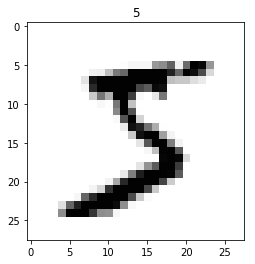

(10000, 28, 28)


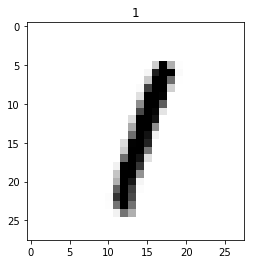

In [25]:

# handle rough data, test

train_dataset = np.ndarray(shape = (len(rough_train_data), img_size, img_size), dtype = np.float32)#init train dataset
num_record = 0 # number of record in train_dataset

train_labels = np.ndarray(shape = len(rough_train_data), dtype = np.int32)


for data in rough_train_data:
    train_dataset[num_record] = (np.asfarray(data[1:]).reshape(img_size,img_size))
    train_labels[num_record] = np.int32(data[0])
    num_record += 1
    

print(train_dataset.shape)
# check your data handle   
plt.title(train_labels[0])
plt.imshow(train_dataset[0], cmap = 'Greys')
plt.show()


test_dataset = np.ndarray(shape = (len(rough_test_data), img_size, img_size), dtype = np.float32)#init train dataset
num_record = 0 # number of record in test_dataset

test_labels = np.ndarray(shape = len(rough_test_data), dtype = np.int32)


for data in rough_test_data:
    test_dataset[num_record] = (np.asfarray(data[1:]).reshape(img_size,img_size))
    test_labels[num_record] = np.int32(data[0])
    num_record += 1
    

print(test_dataset.shape)
# check your data handle   
plt.title(test_labels[5])
plt.imshow(test_dataset[5], cmap = 'Greys')
plt.show()

In [0]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [37]:
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, img_size, img_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (60000, 28, 28, 1) (60000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


**TF graph**

In [0]:
batch_size = 16
depth = 64
depth1 = 64
depth2 = 64

patch_size = 5

num_hidden1 = 1024
num_hidden2 = 512

graph = tf.Graph()

with graph.as_default():
  tf_train_dataset = tf.placeholder(dtype = tf.float32, shape = (batch_size, img_size, img_size, num_channels))
  tf_train_labels = tf.placeholder(dtype = tf.float32, shape = (batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset)
  
  #weight
  #3 conv
  layer1_weight = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev = 0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))

  layer2_weight = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth1], stddev = 0.1))
  layer2_biases = tf.Variable(tf.zeros([depth1]))

  layer3_weight = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev = 0.1))
  layer3_biases = tf.Variable(tf.zeros([depth2]))
  
  # 2 fc
  layer4_weight = tf.Variable(tf.truncated_normal([16*depth2, num_hidden1], stddev = 0.1))
  layer4_biases = tf.Variable(tf.zeros(num_hidden1))

  layer5_weight = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev = 0.1))
  layer5_biases = tf.Variable(tf.zeros(num_hidden2))
  
  # to output
  layer6_weight = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev = 0.1))
  layer6_biases = tf.Variable(tf.zeros(num_labels))
  
  #compute
  def model(data):
      #conv1
      conv = tf.nn.conv2d(input = data, filter = layer1_weight, strides = [1,1,1,1], padding = 'SAME')
      hidden = tf.nn.relu(conv + layer1_biases)
      pooling = tf.nn.max_pool(value = hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
      
      #conv2
      conv = tf.nn.conv2d(input = pooling, filter = layer2_weight, strides = [1,1,1,1], padding = 'SAME')
      hidden = tf.nn.relu(conv + layer2_biases)
      pooling = tf.nn.max_pool(value = hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
      
      #conv3
      conv = tf.nn.conv2d(input = pooling, filter = layer3_weight, strides = [1,1,1,1], padding = 'SAME')
      hidden = tf.nn.relu(conv + layer3_biases)
      pooling = tf.nn.max_pool(value = hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
      
      #fc1
      shape = pooling.get_shape().as_list()
      reshape = tf.reshape(pooling, [shape[0], shape[1]*shape[2]*shape[3]])
      hidden1 = tf.nn.relu(tf.matmul(reshape, layer4_weight) + layer4_biases)
      
      #dropout1
      hidden1 = tf.nn.dropout(hidden1, keep_prob = 0.5)
      
      #fc2 
      hidden2 = tf.nn.relu(tf.matmul(hidden1, layer5_weight) + layer5_biases)

      #dropout2
      hidden2 = tf.nn.dropout(hidden2, keep_prob = 0.5)

      #output
      return tf.matmul(hidden2, layer6_weight) + layer6_biases
    
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = tf_train_labels))
  
  
  #optimizer
  optimizer =tf.train.AdamOptimizer(1e-4).minimize(loss)
  
  #prediction
  train_prediction = tf.nn.softmax(logits)
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

**Run session**

In [39]:
num_step = 100001

with tf.Session(graph = graph) as session:
  tf.global_variables_initializer().run()
  print('Init variable')
    
  for step in range(num_step):
      offset = (batch_size * step) % (train_dataset.shape[0] - batch_size)
      batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
        
      feed_dict = {tf_train_dataset:batch_data, tf_train_labels: batch_labels}
        
      _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
      if (step % 5000 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
        
    
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Init variable
Minibatch loss at step 0: 6548.507812
Minibatch accuracy: 0.0%
Minibatch loss at step 5000: 86.191925
Minibatch accuracy: 68.8%
Minibatch loss at step 10000: 0.989841
Minibatch accuracy: 93.8%
Minibatch loss at step 15000: 2.213579
Minibatch accuracy: 93.8%
Minibatch loss at step 20000: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 25000: 0.128128
Minibatch accuracy: 93.8%
Minibatch loss at step 30000: 1.270296
Minibatch accuracy: 81.2%
Minibatch loss at step 35000: 1.057859
Minibatch accuracy: 93.8%
Minibatch loss at step 40000: 0.614537
Minibatch accuracy: 87.5%
Minibatch loss at step 45000: 0.000236
Minibatch accuracy: 100.0%
Minibatch loss at step 50000: 0.012244
Minibatch accuracy: 100.0%
Minibatch loss at step 55000: 0.044794
Minibatch accuracy: 93.8%
Minibatch loss at step 60000: 0.021655
Minibatch accuracy: 100.0%
Minibatch loss at step 65000: 0.000005
Minibatch accuracy: 100.0%
Minibatch loss at step 70000: 0.000008
Minibatch accuracy: 100.0%
Minibat